In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
from scipy.stats import multivariate_normal as mvn
from jax import config

from runner import run_vsem_experiment, plot_coverage_single_rep

import vsem_jax as vsem
from inverse_problem import InvProb, VSEMPrior, VSEMLikelihood
from surrogate import VSEMTest

import sys
sys.path.append("./../linear_Gaussian/")
from Gaussian import Gaussian

sys.path.append("./../../helpers/")
from mcmc_uncertainty_prop import gpjaxGP, RandomKernelPCNSampler

config.update("jax_enable_x64", True)

/opt/miniconda3/envs/modmcmc-dev/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import seaborn as sns
sns.set_theme(style='white', palette='colorblind') # whitegrid
sns.set_context("paper", font_scale=1.5)

# Specific Paul Tol color scheme when comparing different posteriors
colors = {
    'exact': "#4477AA",
    'mean': "#EE6677",
    'eup': "#228833",
    'ep': "#CCBB44",
    'aux': "#888888"
}

In [4]:
from runner import get_vsem_inv_prob

rng = np.random.default_rng(23521)
n_design = 15
n_test_grid_1d = 50

inv_prob = get_vsem_inv_prob(rng)
test = VSEMTest(inv_prob, n_design=n_design, n_test_grid_1d=n_test_grid_1d)

/opt/miniconda3/envs/modmcmc-dev/lib/python3.13/site-packages/scipy/optimize/_minimize.py:780: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 64.446745
         Iterations: 85
         Function evaluations: 148
         Gradient evaluations: 137


In [ ]:
rng = np.random.default_rng(23521)
n_design = 15
n_test_grid_1d = 50
n_reps = 2

tests, metrics, failed = run_vsem_experiment(rng=rng, 
                                             n_design=n_design, 
                                             n_reps=n_reps, 
                                             n_test_grid_1d=n_test_grid_1d)
test = tests[0]

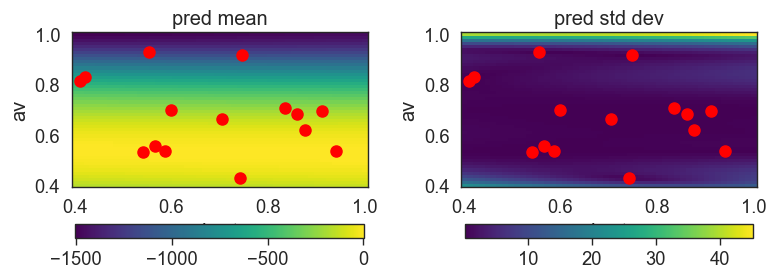

In [5]:
# GP predictions

fig_gp, axs_gp = test.plot_gp_pred(conditional=True, pred_type='pred', markersize=8)
display(fig_gp)
plt.close()

/Users/andrewroberts/Desktop/git-repos/bip-surrogates-paper/experiments/vsem/grid_utils.py:130: RuntimeWarning: overflow encountered in exp
  return (np.exp(log_prob_norm), np.exp(logZ))


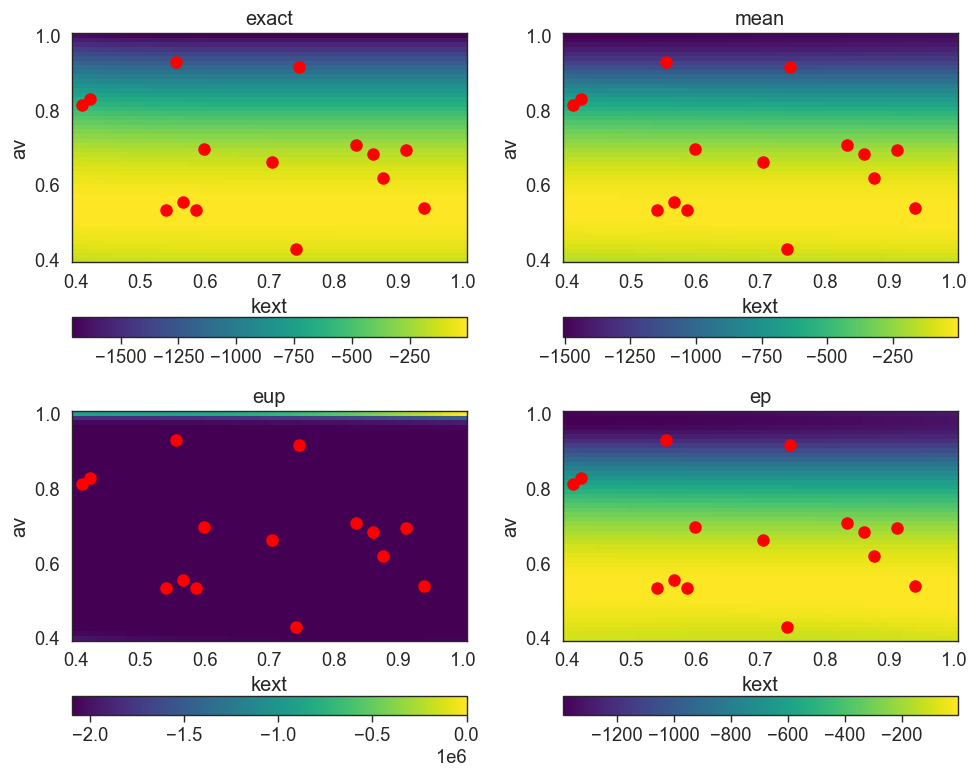

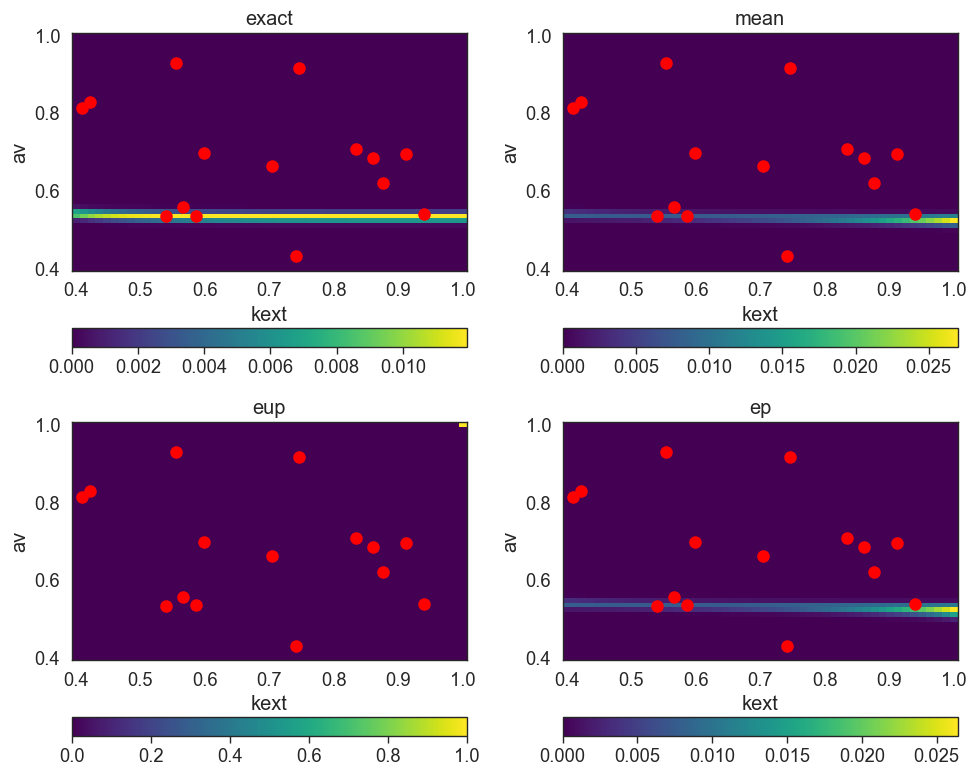

In [8]:
# Comparing posteriors
fig_log, axs_log = test.plot_posterior_comparison(shared_scale=False, log_scale=True,
                                                  pred_type='pred', nrows=2, figsize=(10,8))
fig, axs = test.plot_posterior_comparison(shared_scale=False, log_scale=False, 
                                          pred_type='pred', nrows=2, figsize=(10,8))

display(fig_log)
display(fig)
plt.close()

In [ ]:
cell_area = test.test_grid_info['cell_area']
U = test.test_grid_info['U_grid']
n_grid_1d = test.test_grid_info['n_grid_1d']
pred = test.gp_post_pred['pred']

logp_true = test._exact_post_grid(return_log=True)
logp_approx = test.log_post_approx_mean(U, pred=pred)

In [ ]:
alphas_out, log_cov, calib_log, masks = coverage_curve(
    logp_true,
    logp_approx,
    cell_area=None,
    alphas=np.concatenate([np.arange(0.1, 1.0, 0.1), np.array([0.99])]),
    return_masks=True,
    expand_ties=True,
    normalized_tol=1e-8
)

In [ ]:
print("alpha   log_coverage   coverage (linear)   calib_error_log")
for a, lc, ce in zip(alphas_out, log_cov, calib_log):
    print(f"{a:4.2f}   {lc:12.6f}   {np.exp(lc):12.6e}    {ce:12.6f}")

In [ ]:
# Plot masks
plt.close()
fig, axes = plt.subplots(1, len(alphas_out), figsize=(4 * len(alphas_out), 4))
for ax, a, mask in zip(axes, alphas_out, masks):
    plot_hpd_mask(mask, grid_shape=(n_grid_1d, n_grid_1d), ax=ax, title=f"HPD mask (alpha={a:.2f})")

plt.show()